Image segmentation with Expectation Maximization (EM) 


In [42]:
from google.colab import files
uploaded = files.upload()

Saving flower.jpg to flower (3).jpg


In [0]:
import cv2 
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal

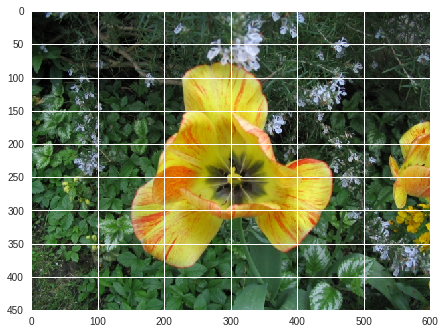

In [44]:
im = cv2.imread('flower.jpg')
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
plt.imshow(im)
plt.show()

### EM


### Initialization 

We start EM algorithm by initializing the parameters randomly. Note that the RGB input image must be downscaled to [0, 1], otherwise the likelihood calculation later will explode. 

### E - Expectation 

Calculate the likelihood of each cluster K for each pixel in the image. Classify pixels by taking the maximum likelihood cluster's label, corresponding annotation can be generated easily. 

### M - Maximization 

Maximize parameters based on the likelihood returned from E step. 

Update rules as in slides: ECSE-626_27_GMM_EM_Parzen_2014-wanimations.pdf, Page 71

In [0]:
def EM(im,K,iters=15, plot=True):
  
  xtrain = np.reshape(im, [-1,3])/255
  
  ### Initialization of parmeters 
  n,d = xtrain.shape            
  mean = xtrain[np.random.choice(n, K, False), :]
  cov = [80*np.eye(d)] * K
  for i in range(K):
    cov[i]=np.multiply(cov[i],np.random.rand(d,d))
  w = [1./K] * K
  z = np.zeros((n, K))


  log_likelihoods = []

  while len(log_likelihoods) < iters:

    ### E step
    for k in range(K):
      tmp = w[k] * multivariate_normal.pdf(xtrain, mean[k], cov[k],allow_singular=True)
      z[:,k]=tmp.reshape((n,))
    
    log_likelihood = np.sum((np.sum(z, axis = 1)))

    log_likelihoods.append(log_likelihood)

    z = (z.T / np.sum(z, axis = 1)).T
    
    
    ### M step
    N_ks = np.sum(z, axis = 0)

    for k in range(K):
      mean[k] = 1. / N_ks[k] * np.sum(z[:, k] * xtrain.T, axis = 1).T
      x_mean = np.matrix(xtrain - mean[k])
      cov[k] = np.array(1 / N_ks[k] * np.dot(np.multiply(x_mean.T,  z[:, k]), x_mean))
      w[k] = 1. / n * N_ks[k]
      
  annot = np.argmax(z, axis=1)
  
  if plot: 
    plt.figure()
    plt.subplot(1,2,1)
    plt.imshow(np.reshape(annot/np.max(annot), im.shape[:2]), cmap='gray')
    plt.title('Segmentation m={}'.format(K))
    plt.subplot(1,2,2)
    plt.imshow(im)
    plt.title('RGB image')
    plt.show()
  return mean, cov, w, annot


### Segmentation results for $m$ in range $2-8$

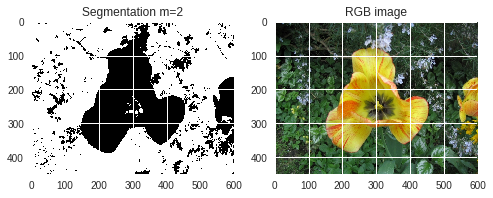

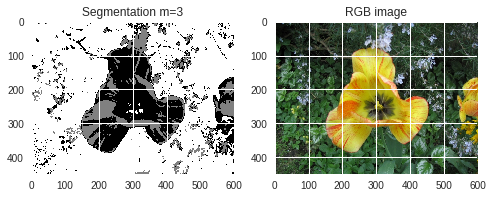

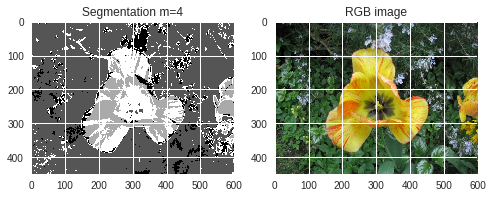

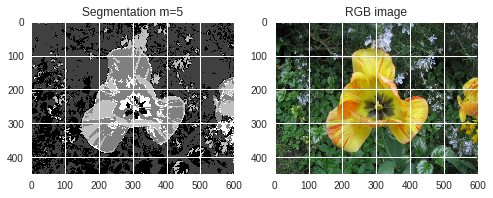

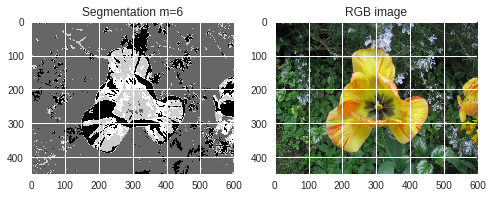

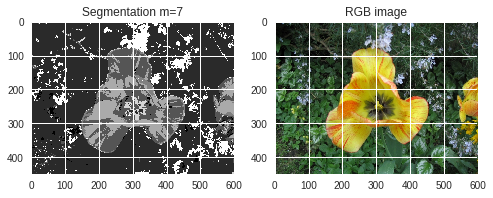

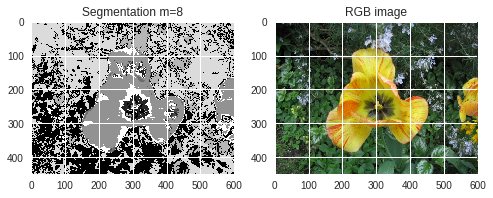

In [73]:
for m in range(2, 9):
  mean, Sigma, w, annot = EM(im, m)

### Selecte the best model 
* Using BIC to find a score for each model (averaged with 5 random initializations). 
* BIC punishes model complexity
*  $n$ is total number of pixels, $m$ is total number of parameters, $\theta$ is parameters
* $BIC\approx mln(n)-2\sum_{x_i\in X}ln(p(x_i|\theta))$

Note that BIC value is **not necessarily positive**, bacause normal distribution is not bounded, when covariance matrix is small, pdf value of the distribution could be larger than 1, leading to positive $log$ probability which could result in negative BIC value. 

In [0]:
def BIC(im, K):
  n = im.shape[0] * im.shape[1]
  trainx = np.reshape(im, [-1, 3]).astype(np.float)/255
  
  mean, Sigma, w, annot = EM(im, K, plot=False)
  
  m = np.array(mean).size + np.array(Sigma).size + np.array(w).size
  
  z = np.zeros((n, K))
  for k in range(K):
      tmp = w[k] * multivariate_normal.pdf(trainx, mean[k], Sigma[k],allow_singular=True)
      z[:,k]=tmp.reshape((n,))
      
  likelihood = np.sum(z, axis=1)
  
  bic = m*np.log(n) - 2*np.sum(np.log(likelihood))
  
  return bic

### BIC plot & analysis

BIC value for each type of model can be found as below. Based on the trend plot, using 6 components leads to the smallest BIC value. However, the BIC value of 5 components is very close to 6. Since the simpler, the better, the best model should be using 5 components. 

In [0]:
bics = []
for m in range(2, 9):
  bic = 0
  for _ in range(5):
    bic += BIC(im, m)
  bics.append(np.mean(bic))

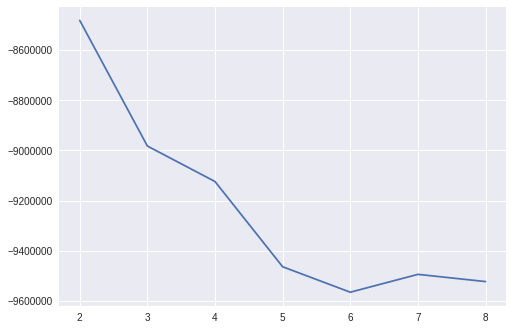

In [89]:
plt.plot(range(2,9), bics)
plt.show()